# Bank Marketing Dataset - Machine Learning Zoomcamp Homework

In this notebook, we'll analyze the Bank Marketing dataset and perform several tasks, including data preparation, correlation analysis, logistic regression, and feature elimination.


## Data Loading and Preparation

Here, we'll load the dataset and perform the initial data preparation steps:

In [3]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load the csv file
df = pd.read_csv('bank/bank-full.csv', delimiter=';')

# Display the first few rows of the dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Feature Selection and Missing Values

In [5]:
# Select only the required columns
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]

# Check for missing values
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1: Mode of the Education Column

In [6]:
# Find the mode of the education column
education_mode = df['education'].mode()[0]
print(f"The mode for the education column is: {education_mode}")

The mode for the education column is: secondary


### Question 2: Correlation Matrix

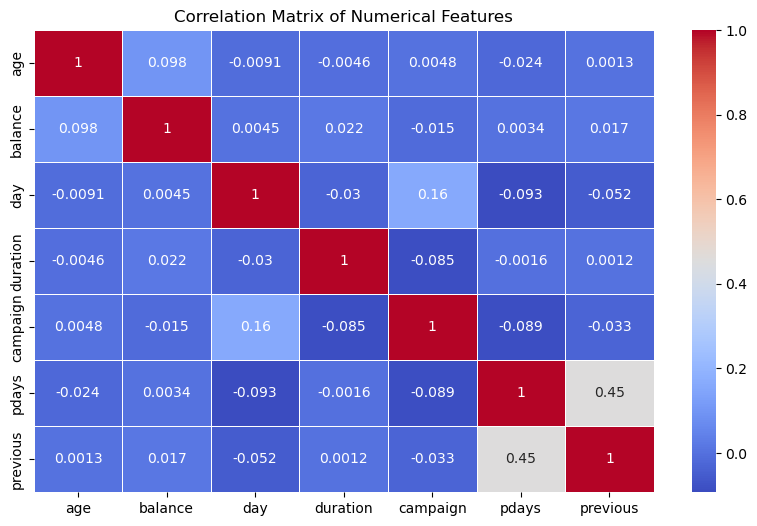

In [7]:
# Select numerical features
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Compute the correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### Target Encoding

In [8]:
# Encode target variable y (yes/no to 1/0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

### Data Splitting

In [9]:
# Split the data into training, validation, and test sets (60%/20%/20%)
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

### Question 3: Mutual Information Score

In [10]:
from sklearn.feature_selection import mutual_info_classif

# Extract categorical features
categorical_features = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

# Mutual information score calculation
X_train = df_train[categorical_features]
y_train = df_train['y']

# Convert categorical features to numerical using one-hot encoding
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Calculate mutual information score
mi_scores = mutual_info_classif(X_train_encoded, y_train)
mi_scores = pd.Series(mi_scores, index=X_train_encoded.columns).sort_values(ascending=False)

# Display the mutual information scores
mi_scores.round(2)

poutcome_success       0.03
contact_unknown        0.02
housing_yes            0.02
poutcome_unknown       0.01
education_secondary    0.01
month_sep              0.01
marital_married        0.01
job_student            0.00
poutcome_other         0.00
month_oct              0.00
marital_single         0.00
month_may              0.00
month_aug              0.00
job_unknown            0.00
job_retired            0.00
job_entrepreneur       0.00
month_jul              0.00
job_blue-collar        0.00
month_mar              0.00
month_jan              0.00
job_services           0.00
education_tertiary     0.00
month_nov              0.00
job_management         0.00
month_dec              0.00
job_technician         0.00
job_unemployed         0.00
job_self-employed      0.00
month_feb              0.00
month_jun              0.00
contact_telephone      0.00
education_unknown      0.00
job_housemaid          0.00
dtype: float64

### Question 4: Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# One-hot encode categorical features for logistic regression
X_train_full = pd.get_dummies(df_train.drop('y', axis=1), drop_first=True)
X_val_full = pd.get_dummies(df_val.drop('y', axis=1), drop_first=True)

y_train = df_train['y']
y_val = df_val['y']

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_full, y_train)

# Validate the model
y_pred = model.predict(X_val_full)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {accuracy:.2f}")

Validation accuracy: 0.90


### Question 5: Feature Elimination

In [12]:
# Train model with all features (baseline)
baseline_accuracy = accuracy_score(y_val, model.predict(X_val_full))

# Evaluate feature elimination
features = X_train_full.columns
accuracy_diffs = {}

for feature in features:
    X_train_new = X_train_full.drop(columns=[feature])
    X_val_new = X_val_full.drop(columns=[feature])
    
    model.fit(X_train_new, y_train)
    accuracy_new = accuracy_score(y_val, model.predict(X_val_new))
    accuracy_diffs[feature] = baseline_accuracy - accuracy_new

# Find feature with the smallest difference
smallest_diff_feature = min(accuracy_diffs, key=accuracy_diffs.get)
print(f"Feature with the smallest difference: {smallest_diff_feature}")

Feature with the smallest difference: month_jul


### Question 6: Regularized Logistic Regression

In [13]:
# Try different values of C for regularization
C_values = [0.01, 0.1, 1, 10, 100]
best_C = None
best_accuracy = 0

for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_full, y_train)
    accuracy = accuracy_score(y_val, model.predict(X_val_full))
    print(f"C={C}: Validation accuracy = {accuracy:.3f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Best C value: {best_C}")

C=0.01: Validation accuracy = 0.898
C=0.1: Validation accuracy = 0.900
C=1: Validation accuracy = 0.901
C=10: Validation accuracy = 0.900
C=100: Validation accuracy = 0.901
Best C value: 1


## Conclusion

- The mode for the education column issecondary..`.
- The strongest correlation is betweepdays...` anprevious...`.
- The best logistic regression model has an accuracy 0.901`...`.
- The least useful featuremonth_jul `...`, and the best value for C1 `.`.

